Imports

In [2]:
import glob
import mediapy as media
import cv2
import random
import mediapy as media
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Util

In [1]:
files_soil = (glob.glob("Data/*soil.png"))
files_tree = (glob.glob("Data/*tree.png"))

print("Total files soil:",len(files_soil))
print("Total files tree:",len(files_tree))

Total files soil: 4448
Total files tree: 2224


* Theres a double inquantity of images for the soil class
* All the images are shaped in a 50x50x3
* Overall a goos quantity of images, maybe deep learning aproach is suitable

# Morpholic and Sampling evaluation

Soil:810,Soil:3943,Soil:3260,Soil:1203,Soil:3714,Soil:570,Soil:1267,Soil:3190,Soil:3680,Soil:2909

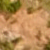
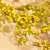
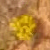
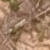
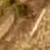
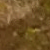
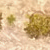
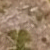
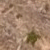
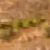

Tree:94,Tree:1849,Tree:141,Tree:1036,Tree:1363,Tree:1275,Tree:1555,Tree:1248,Tree:411,Tree:470

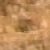
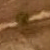
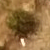
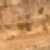
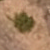
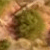
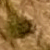
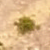
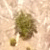
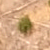

In [4]:
total_samples = 10

soil_idx = [random.randint(0, len(files_soil)-1) for i in range(total_samples)]
tree_idx = [random.randint(0, len(files_tree)-1) for i in range(total_samples)]

soil_imgs = {}
tree_imgs = {}

for idx in soil_idx: soil_imgs.update({'Soil:'+str(idx):media.read_image(files_soil[idx])})
for idx in tree_idx: tree_imgs.update({'Tree:'+str(idx):media.read_image(files_tree[idx])})
    
media.show_images(soil_imgs, vmin=0.0, vmax=1.0, border=True, height=100)
media.show_images(tree_imgs, vmin=0.0, vmax=1.0, border=True, height=100)

* Seens that the a tree image is only valid if is centered on the cropped section
* The soil images maybe contains some partial portions of tree or grass
* The only color apporach maybe not availabel due the soil images maybe contains green tonalities
* The size of the green blob refers to the size of the tree, in some cases I believe that theres a tree, but to young to be counted
* The tree are overall well shaped, as a circular in the center of the image
* Some corner images contains a black besel, that maybe interfir in some trainings
* Seems the each tree have a minimal distece from another, there's no much aglomeration

### Complex Cases

(a) - False Tree

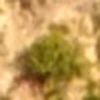

b.1 Soil:3339,b.2 Tree:1340

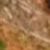
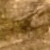

c.1 Soil:4243,c.2 Tree:1889

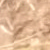
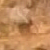

d.1 Soil:4169,d.2 Tree:993

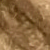
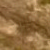

In [5]:
media.show_image(media.resize_image(media.read_image(files_soil[1949]),(100,100)),title='(a) - False Tree')

total_samples = 10

indexes = [[3339,1340],
           [4243,1889],
           [4169,993]]

labels = ['b','c','d']

for i, idx in enumerate(indexes):

    imgs = {}

    imgs.update({labels[i]+'.1 Soil:'+str(idx[0]):media.read_image(files_soil[idx[0]])})
    imgs.update({labels[i]+'.2 Tree:'+str(idx[1]):media.read_image(files_tree[idx[1]])})
    
    media.show_images(imgs, vmin=0.0, vmax=1.0, border=True, height=100)

* The cases cases listed on the previous images are on the "easy" range, were they are well defined
* For instance the first row (a) contains a set of rules cited before (uniforme shape, centered, no neigours), and even on this case is consider as soil
* The following cases (b, c and d) we show a breafly comparation betwen cases, on the naked eye we can not (or barely describe) if theres a tree o not, in correlation to soil cases
* Maybe this can interfir in some treiing process

# Histogram analisys

In [6]:
#FUnction to get the histogram of each channel
def get_splited_hist(img):
    
    b,g,r = cv2.split(img)

    hist_b = cv2.calcHist([b],[0],None,[256],[0,256])
    hist_g = cv2.calcHist([g],[0],None,[256],[0,256])
    hist_r = cv2.calcHist([r],[0],None,[256],[0,256])

    return hist_b.flatten(), hist_g.flatten(), hist_r.flatten()

#GEt the average for each type of class
paths_files = [files_soil,files_tree]

#General array of metrics
hists_arr = []

#Lopp for the images loading
for path_single in paths_files:
    
    hists = []

    for path in path_single:

        img  = cv2.imread(path)
        grey = cv2.imread(path,0)
        
        hist_grey = cv2.calcHist([grey],[0],None,[256],[0,256]).flatten()

        hist_b, hist_g, hist_r = get_splited_hist(img)

        if (len(hists)==0):

            hists.append(hist_b)
            hists.append(hist_g)
            hists.append(hist_r)
            hists.append(hist_grey)

        else:

            hists[0] = np.vstack((hists[0],hist_b))
            hists[1] = np.vstack((hists[1],hist_g))
            hists[2] = np.vstack((hists[2],hist_r))
            hists[3] = np.vstack((hists[3],hist_grey))

    hist_average_b = np.mean(hists[0],axis=0)
    hist_average_g = np.mean(hists[1],axis=0)
    hist_average_r = np.mean(hists[2],axis=0)
    hist_average_grey = np.mean(hists[3],axis=0)
    
    output = [hist_average_b,hist_average_g,hist_average_r,hist_average_grey]
    hists_arr.append(output)

### Ploting the histogram

In [7]:
#Scale to stand the dota [0,1]
scaler = MinMaxScaler()

#Simple caption handle
caption = ['Soil','Tree']

for i,hists in enumerate(hists_arr):


    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
    axes[0].plot(scaler.fit_transform(hists[0].reshape(-1,1)).flatten(), color='b')
    axes[0].title.set_text(caption[i]+' - Blue histogram')
    axes[1].plot(scaler.fit_transform(hists[1].reshape(-1,1)).flatten(), color='g')
    axes[1].title.set_text(caption[i]+' - Green histogram')
    axes[2].plot(scaler.fit_transform(hists[2].reshape(-1,1)).flatten(), color='r')
    axes[2].title.set_text(caption[i]+' - Red histogram')
    axes[3].plot(scaler.fit_transform(hists[3].reshape(-1,1)).flatten(), color='black')
    axes[3].title.set_text(caption[i]+' - Grayscale histogram')
    fig.tight_layout()

    plt.show()

ModuleNotFoundError: No module named 'sklearn'

* We get histogram from eachs filter, but as excpeted, we coul not acquire much information
* The normalized histogram in each image range to similar
* I believe that the image size (2500 pixels per channel), reduce the capabilites based on a color solution
* Some bias could be include, since the diference of the datasets sizes (tree and soil)
* The soil have a peak on close to 0 pixel on the red and green histogram, even with a large distribuitn around the center, we can maybe use the histogram as aditional feature to the decision making
* We could use some HSV segmentation, but we need prior information, and as metioned before, some tree examples does not present a good distictin between tree and background